**Installing and Importing libraries**

In [ ]:
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
#!git clone https://github.com/EliSchwartz/imagenet-sample-images.git imagenet
#!mkdir data
#!mv imagenet data/
!mkdir extra

In [ ]:
import re
import io
import cv2
import pdb
import os
import os
import cv2
import glob
import keras
import random
import requests
import numpy as np
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import keras.layers as layers
import keras.models as models
import matplotlib.pylab as plt
from keras import backend as K
from torch.autograd import Variable
from torch.nn import functional as F
from keras.preprocessing import image
from keras.optimizers import SGD, Adam
from keras.initializers import orthogonal
from keras.applications.resnet50 import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

In [ ]:
%reload_ext autoreload
%matplotlib inline
%autoreload 2

Unzipping Data


In [ ]:
!unzip test.zip

Importing Model and Labels

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,weights='imagenet')
pretrained_model.trainable = False
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

  
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]


14540800/14536120 [==============================] - 0s 0us/step


In [ ]:
batch_size =1
epochs = 150
input_shape = (224, 224)

Setting Autoencoder layers

In [ ]:
def Conv2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = layers.Conv2D(filters, kernel_size=kernel, strides=strides, padding=padding,kernel_initializer=kernel_init, name=prefix+'conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

def Transpose_Conv2D(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = layers.Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding=padding,kernel_initializer=kernel_init, name=prefix+'de-conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x



def AutoEncdoer(input_shape):
    inputs = layers.Input(shape=input_shape)
    conv1 = Conv2DLayer(inputs, 64, 3, strides=1, padding='same', block_id=1)
    conv2 = Conv2DLayer(conv1, 64, 3, strides=2, padding='same', block_id=2)
    conv3 = Conv2DLayer(conv2, 128, 5, strides=2, padding='same', block_id=3)
    conv4 = Conv2DLayer(conv3, 128, 3, strides=1, padding='same', block_id=4)
    conv5 = Conv2DLayer(conv4, 256, 5, strides=2, padding='same', block_id=5)
    conv6 = Conv2DLayer(conv5, 512, 3, strides=2, padding='same', block_id=6)
    conv7 = Conv2DLayer(conv6, 1024, 3, strides=2, padding='same', block_id=60)
    deconv0 = Transpose_Conv2D(conv7, 1024, 3, strides=2, padding='same', block_id=7)
    skip0 = layers.concatenate([deconv0, conv6], name='skip0')
    conv77 = Conv2DLayer(skip0, 512, 3, strides=1, padding='same', block_id=80)
    deconv1 = Transpose_Conv2D(conv77, 256, 3, strides=2, padding='same', block_id=90)

    skip1 = layers.concatenate([deconv1, conv5], name='skip1')
    conv7 = Conv2DLayer(skip1, 256, 3, strides=1, padding='same', block_id=8)
    deconv2 = Transpose_Conv2D(conv7, 128, 3, strides=2, padding='same', block_id=9)
    skip2 = layers.concatenate([deconv2, conv3], name='skip2')
    conv8 = Conv2DLayer(skip2, 128, 5, strides=1, padding='same', block_id=10)
    deconv3 = Transpose_Conv2D(conv8, 64, 3, strides=2, padding='same', block_id=11)
    skip3 = layers.concatenate([deconv3, conv2], name='skip3')
    conv9 = Conv2DLayer(skip3, 64, 5, strides=1, padding='same', block_id=12)
    deconv4 = Transpose_Conv2D(conv9, 64, 3, strides=2, padding='same', block_id=13)
    skip3 = layers.concatenate([deconv4, conv1])
    conv10 = layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid',kernel_initializer=orthogonal(), name='final_conv')(skip3)
    return models.Model(inputs=inputs, outputs=conv10)

In [ ]:
model = AutoEncdoer((*input_shape, 3))
model_opt = Adam(lr=0.002)
model.compile(optimizer=model_opt, loss='mse', metrics=['accuracy'])

**Importing Images**

In [ ]:
all_images = []
from keras.preprocessing import image
error = 0
face_images = glob.glob('dataset/*')
for i in tqdm(face_images):
  img = image.load_img(i, target_size=(224,224,3))
  img = image.img_to_array(img)
  img = img/255.
  all_images.append(img)
print("Total Faulty Images ",error)
all_images = np.array(all_images)
train_x, val_x = train_test_split(all_images, random_state=32, test_size=0.4 , shuffle = False)

100%|██████████| 239/239 [00:00<00:00, 676.00it/s]


Total Faulty Images  0


Setting up attack variables

In [ ]:
from cleverhans.tf2.attacks import fast_gradient_method
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
logits_model = tf.keras.Model(pretrained_model.input,pretrained_model.layers[-1].output)

def attack(image):
  epsilon = 0.1
  adv_example_untargeted_label = fast_gradient_method(logits_model, image, 0.1 , np.inf, targeted=False)
  adv_example_untargeted_label_pred = pretrained_model.predict((adv_example_untargeted_label))
  return adv_example_untargeted_label[0]

Creating Training and testing Data

In [ ]:
train_x_px = []
val_x_px = []

for i in range(train_x.shape[0]):
  temp = attack(train_x[None,i,:,:,:])
  train_x_px.append(temp)

for i in range(val_x.shape[0]):
  temp = attack(val_x[None,i,:,:,:])
  val_x_px.append(temp)

train_x_px = np.array(train_x_px)
val_x_px = np.array(val_x_px)

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', mode='auto')

model.fit(train_x_px, train_x,
            epochs=20,
            batch_size=25,
            validation_data=(val_x_px, val_x))

Epoch 1/20
32/32 [==============================] - 22s 696ms/step - loss: 0.0030 - accuracy: 0.7447 - val_loss: 0.0023 - val_accuracy: 0.7653
Epoch 2/20
32/32 [==============================] - 22s 700ms/step - loss: 0.0032 - accuracy: 0.7457 - val_loss: 0.0023 - val_accuracy: 0.7590
Epoch 3/20
32/32 [==============================] - 23s 710ms/step - loss: 0.0030 - accuracy: 0.7532 - val_loss: 0.0023 - val_accuracy: 0.7655
Epoch 4/20
32/32 [==============================] - 23s 712ms/step - loss: 0.0030 - accuracy: 0.7502 - val_loss: 0.0023 - val_accuracy: 0.7668
Epoch 5/20
32/32 [==============================] - 23s 716ms/step - loss: 0.0031 - accuracy: 0.7567 - val_loss: 0.0023 - val_accuracy: 0.7666
Epoch 6/20
32/32 [==============================] - 23s 720ms/step - loss: 0.0030 - accuracy: 0.7508 - val_loss: 0.0023 - val_accuracy: 0.7632
Epoch 7/20
32/32 [==============================] - 23s 720ms/step - loss: 0.0030 - accuracy: 0.7490 - val_loss: 0.0024 - val_accuracy: 0.7618

In [ ]:
model.save_weights("okish_2.h5")

Downloading saved weights from google Drive

In [ ]:
!gdown --id 1_i2tl6_BiFBGAMrlH5kqeKNAyagwmvkE

Downloading...
From: https://drive.google.com/uc?id=1_i2tl6_BiFBGAMrlH5kqeKNAyagwmvkE
To: /content/okish_2.h5
110MB [00:02, 47.4MB/s]


Loading Weights

In [ ]:
model.load_weights("okish_2.h5")

Output of Autoencoder


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


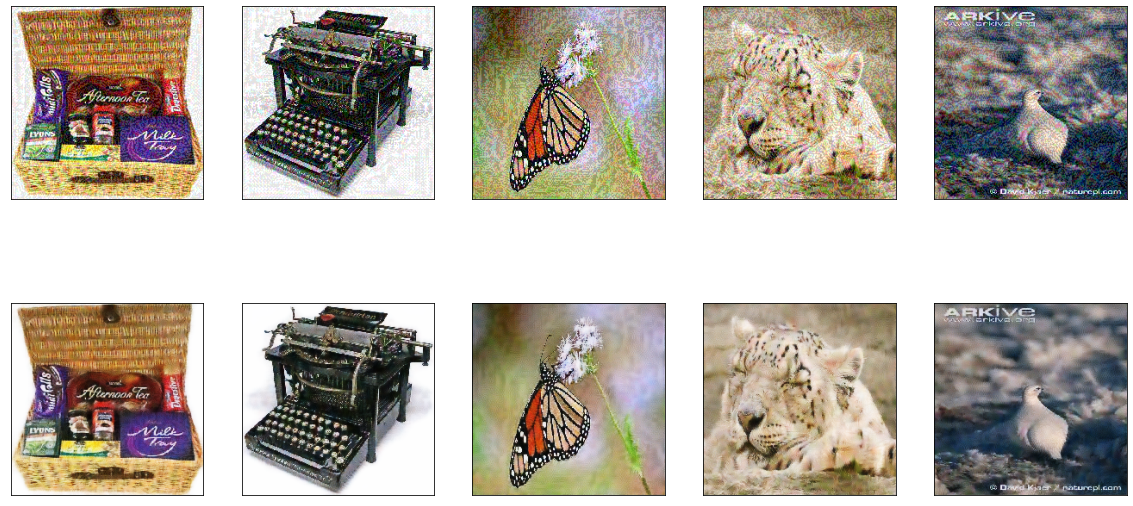

In [ ]:
predictions = model.predict(val_x_px)

n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(val_x_px[i+25])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(predictions[i+25])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

Bringing randomization in our classification Model

In [ ]:
model_id = 2
if model_id == 1:
    squeezenet = models.squeezenet1_1(pretrained=True)
elif model_id == 2:
    resnet = ResNet50(weights='imagenet')
elif model_id == 3:
    densenet = models.densenet161(pretrained=True)

for layer in resnet.layers:
    layer.trainable = False

random_noise = [0.001,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009]

before = []
for i in range(10):
  image = val_x[i][None,:,:,:]
  original = Image.fromarray((image[0]*255).astype(np.uint8),"RGB")
  original.save('extra/original.jpg')
  _, classes_auto, probs = get_imagenet_label(resnet.predict((cv2.imread('extra/original.jpg')[None,:,:,:])))
  before.append((classes_auto, probs))

for i in range(50,100):
  tem = resnet.layers[i].get_weights()
  for j in range(len(tem)):
    tem[j] += np.average(tem[j])*random.choice(random_noise)
  resnet.layers[i].set_weights(tem)

after = []

for i in range(10):
  image = val_x[i][None,:,:,:]
  original = Image.fromarray((image[0]*255).astype(np.uint8),"RGB")
  original.save('extra/original.jpg')
  _, classes_auto, probs = get_imagenet_label(resnet.predict((cv2.imread('extra/original.jpg')[None,:,:,:])))
  after.append((classes_auto, probs))

for i in range(len(before)):
  print("Image :",i)
  print(before[i],after[i])

Image : 0
('hoopskirt', 0.9387997) ('hoopskirt', 0.93856806)
Image : 1
('overskirt', 0.7321544) ('overskirt', 0.7328937)
Image : 2
('nematode', 0.9002769) ('nematode', 0.8995154)
Image : 3
('pop_bottle', 0.6215648) ('pop_bottle', 0.62187445)
Image : 4
('viaduct', 0.99998236) ('viaduct', 0.99998236)
Image : 5
('canoe', 0.9977543) ('canoe', 0.9977708)
Image : 6
('balloon', 0.9997303) ('balloon', 0.99972945)
Image : 7
('shield', 0.99995685) ('shield', 0.9999567)
Image : 8
('pillow', 0.9982679) ('pillow', 0.998278)
Image : 9
('bolo_tie', 0.9515009) ('bolo_tie', 0.9516151)


In [ ]:
from torchvision import models, transforms
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
model_id = 2
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet50(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

net.eval()

features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    size_upsample = (224, 224)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Displaying some Examples with Autoencoder output and Grad-CAM


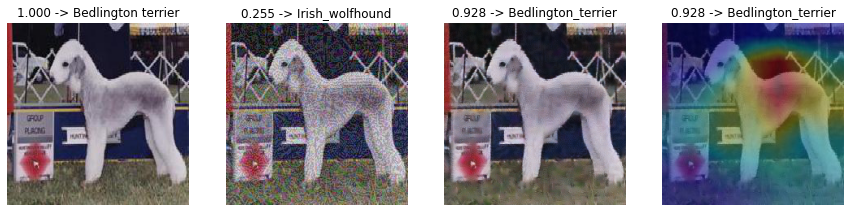

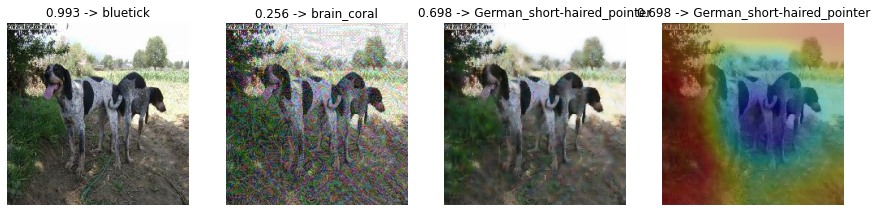

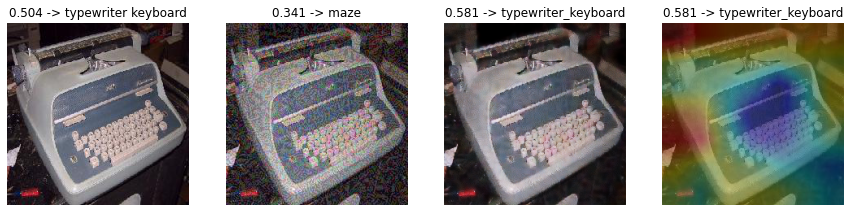

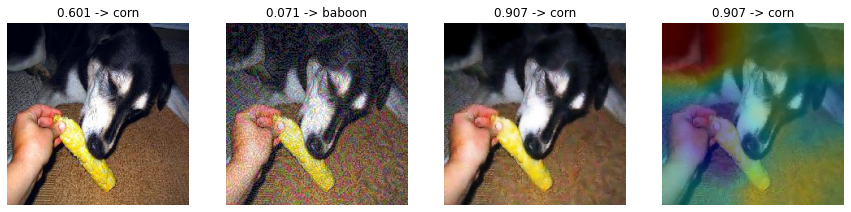

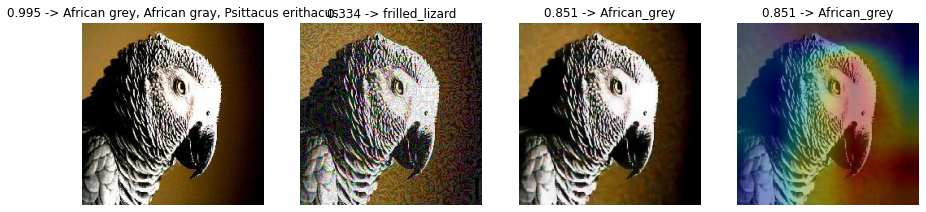

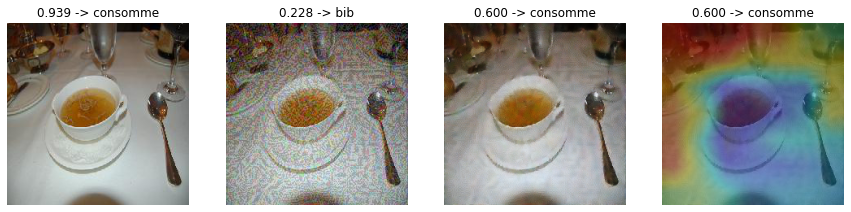

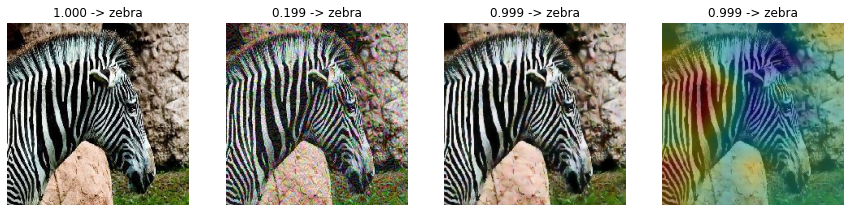

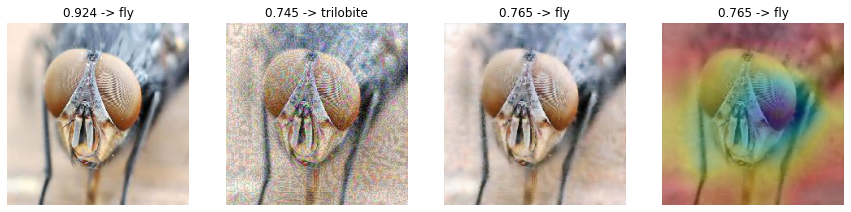

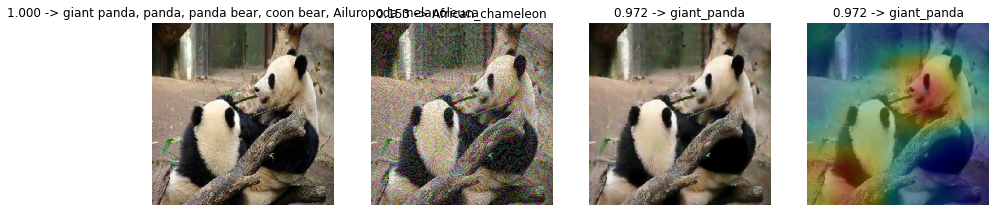

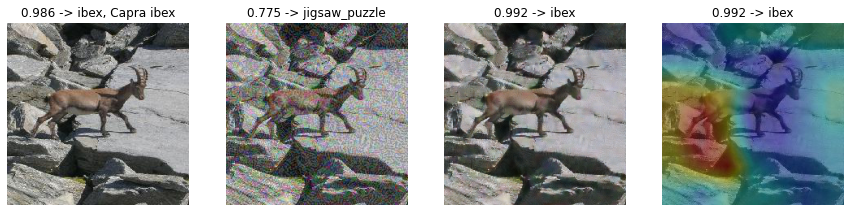

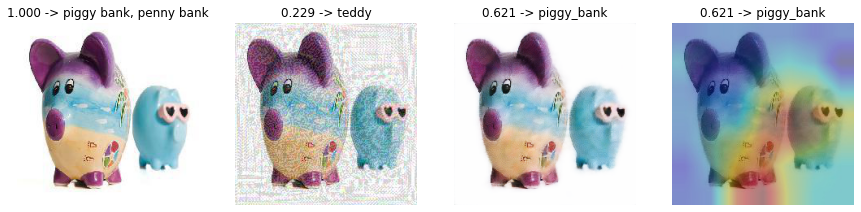

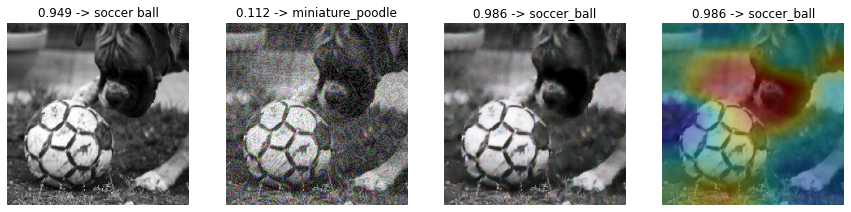

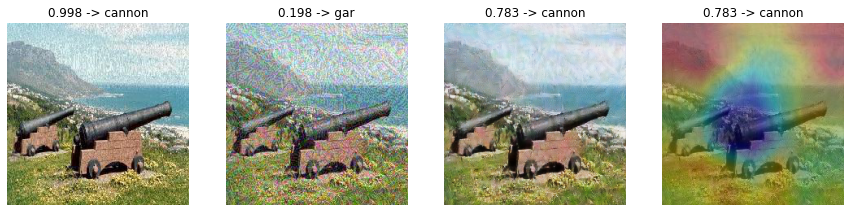

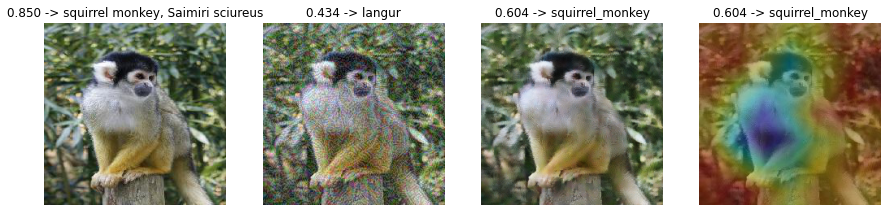

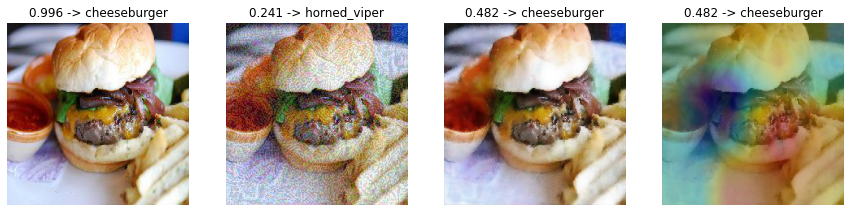

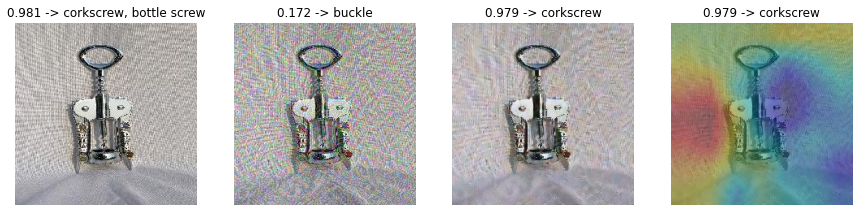

In [ ]:
for i in range(50,70):
  image = all_images[i][None,:,:,:]
  original = Image.fromarray((image[0]*255).astype(np.uint8),"RGB")
  original.save('extra/original.jpg')
  attack_img = fast_gradient_method(logits_model, image, 0.1 , np.inf, targeted=False)
  tf.keras.preprocessing.image.save_img('extra/attack.jpg',attack_img[0])
  auto_enc = model.predict(attack_img)
  im = Image.fromarray((auto_enc[0]*255).astype(np.uint8),"RGB")
  im.save('extra/auto_enc.jpg')

  predc = []

  img_tensor = preprocess(original)
  img_variable = Variable(img_tensor.unsqueeze(0))
  logit = net(img_variable)
  h_x = F.softmax(logit, dim=1).data.squeeze()
  probs, idx = h_x.sort(0, True)
  probs = probs.numpy()
  idx = idx.numpy()
  predc.append('{:.3f} -> {}'.format(probs[0], classes[idx[0]]))

  _, classes_auto, probs = get_imagenet_label(pretrained_model.predict(attack_img))
  predc.append('{:.3f} -> {}'.format(probs, classes_auto))

  _, classes_auto, probs = get_imagenet_label(resnet.predict((cv2.imread('extra/auto_enc.jpg')[None,:,:,:])))
  predc.append('{:.3f} -> {}'.format(probs, classes_auto))

  CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

  #print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
  img = cv2.imread('extra/attack.jpg')
  height, width, _ = img.shape
  heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
  result = heatmap * 0.3 + img * 0.5
  cv2.imwrite('extra/CAM_attack.jpg', result)

  img = cv2.imread('extra/original.jpg')
  height, width, _ = img.shape
  heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
  result = heatmap * 0.3 + img * 0.5
  cv2.imwrite('extra/CAM_original.jpg', result)

  img = cv2.imread("extra/auto_enc.jpg")
  height, width, _ = img.shape
  heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
  result = heatmap * 0.3 + img * 0.5
  cv2.imwrite('extra/CAM_au.jpg', result)

  fig = plt.figure(figsize=(15, 5))

  fig.add_subplot(1, 4, 1)
  plt.imshow((image[0] * 255).astype(np.uint8))
  plt.axis('off')
  plt.title(predc[0])

  fig.add_subplot(1, 4, 2)
  plt.imshow(Image.open('extra/attack.jpg'))
  plt.axis('off')
  plt.title(predc[1])

  fig.add_subplot(1, 4, 3)
  plt.imshow(im)
  plt.axis('off')
  plt.title(predc[2])

  fig.add_subplot(1, 4, 4)
  plt.imshow(Image.open('extra/CAM_au.jpg'))
  plt.axis('off')
  plt.title(predc[2])

  #fig.add_subplot(1, 5, 5)
  #plt.imshow(Image.open('extra/CAM_attack.jpg'))
  #plt.axis('off')
  #plt.title(predc[1])

  fig.show()


In [ ]:
attack_success = 0
attack_failed = 0
defense_success = 0
defense_failed = 0
epsilon = 0.01
resnet = ResNet50(weights='imagenet')
for layer in resnet.layers:
    layer.trainable = False

for i in range(len(val_x)):
  image = val_x[i][None,:,:,:]
  adv_example_untargeted_label = fast_gradient_method(logits_model, image, 0.1 , np.inf, targeted=False)
  adv_example_untargeted_label_pred = pretrained_model.predict((adv_example_untargeted_label))
  _, image_class_at, class_confidence_at = get_imagenet_label(adv_example_untargeted_label_pred)
  #print('Attack : {} : {:.2f}% Confidence'.format(image_class_at, class_confidence_at*100) , end = "\t\t")
  image_probs = pretrained_model.predict((image))
  _, image_class_o, class_confidence_o = get_imagenet_label(image_probs)
  #print('Original : {} : {:.2f}% Confidence'.format(image_class_o, class_confidence_o*100) , end = "\t\t")
  
  im = Image.fromarray((model.predict(adv_example_untargeted_label)[0]*255).astype(np.uint8),"RGB")
  im.save('extra/attack.jpg')
  _, image_class_au, class_confidence_au = get_imagenet_label(resnet.predict((cv2.imread('extra/attack.jpg')[None,:,:,:])))
  #print('Auto : {} : {:.2f}% Confidence'.format(image_class_au, class_confidence_au*100))

  if image_class_au != image_class_o:
    defense_failed += 1
    #print('Original : {} : {:.2f}% Confidence'.format(image_class_o, class_confidence_o*100) , end = "\t\t")
    #print('Attack : {} : {:.2f}% Confidence'.format(image_class_at, class_confidence_at*100) , end = "\t\t")
    #print('Auto : {} : {:.2f}% Confidence'.format(image_class_au, class_confidence_au*100),i)
  else:
    defense_success += 1
  if image_class_at == image_class_o:
    attack_failed += 1
  else:
    attack_success += 1
#print(attack_success,attack_failed,defense_success,defense_failed)

print("-+---------------------------------------------+-")
print(" |  Attack Succesfully Performed in :",attack_success,"images|")
print(" |  Attack failed in :",attack_failed,"images                |")
print("-+---------------------------------------------+-")
print(" |  Defense succesfull in :",defense_success,"images          |")
print(" |  Defense failed in :",defense_failed,"images              |")
print("-+---------------------------------------------+-")
print(" |  Attack Model Accuracy : {:0.2f}%             |".format(attack_success))
print(" |  Defense Model Accuracy : {:0.2f}%            |".format(defense_success/len(val_x)*100))
print("-+---------------------------------------------+-")

-+---------------------------------------------+-
 |  Attack Succesfully Performed in : 87 images|
 |  Attack failed in : 9 images                |
-+---------------------------------------------+-
 |  Defense succesfull in : 85 images          |
 |  Defense failed in : 11 images              |
-+---------------------------------------------+-
 |  Attack Model Accuracy : 87.00%             |
 |  Defense Model Accuracy : 88.54%            |
-+---------------------------------------------+-


In [ ]:
|95 8 84 19

125 15 102 38

EXTRA

for i in range(len(good)):
  img_pil = Image.fromarray((good[i]*255).astype(np.uint8),"RGB")
  img_pil.save('dataset/{}.jpg'.format(i+239))

!kaggle datasets download -d mikewallace250/tiny-imagenet-challenge
!unzip \*.zip  && rm *.zip

def display_images(image):
  #_, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image)
  #plt.title('{} \n {} : {:.2f}% Confidence'.format(description,                                                   label, confidence*100))
  plt.show()

def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image


P_MODELSAVE = 'saved_models'
P_LOGS = 'logs'
P_IMGSAVE = 'saved_images'

dirs = [P_MODELSAVE, P_LOGS, P_IMGSAVE]

for d in dirs:
    if not os.path.exists(d):
        os.makedirs(d)

         count = 0
failed = 0
saved = 0
correct = []
#pretrained_model = pred
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
logits_model = tf.keras.Model(pred.input,pred.layers[-1].output)
epsilon = 0.01
for i in range(999):
  image = all_images[None,i,:,:,:]
  image_probs = pretrained_model.predict((image))
  _, image_class_o, class_confidence_o = get_imagenet_label(image_probs)
  
  im = Image.fromarray((image[0]*255).astype(np.uint8),"RGB")
  im.save('test.png')
  _, image_class_au, class_confidence_au = get_imagenet_label(resnet.predict((cv2.imread('test.png')[None,:,:,:])))
  

  
  if image_class_au == image_class_o:
    #print('Original : {} : {:.2f}% Confidence'.format(image_class_o, class_confidence_o*100) , end = "\t\t")
    #print('Orig_res : {} : {:.2f}% Confidence'.format(image_class_au, class_confidence_au*100))
    count+=1
    correct.append(image[0])
print(count)



count = 0
failed = 0
saved = 0
#pretrained_model = pred

logits_model = tf.keras.Model(pred.input,pred.layers[-1].output)
epsilon = 0.01
actual = []
for i in range(200):
  image = all_images[None,i,:,:,:]
  adv_example_untargeted_label = fast_gradient_method(logits_model, image, 0.1 , np.inf, targeted=False)
  adv_example_untargeted_label_pred = pretrained_model.predict((adv_example_untargeted_label))
  _, image_class_at, class_confidence_at = get_imagenet_label(adv_example_untargeted_label_pred)
  #print('Attack : {} : {:.2f}% Confidence'.format(image_class_at, class_confidence_at*100) , end = "\t\t")
  image_probs = pretrained_model.predict((image))
  _, image_class_o, class_confidence_o = get_imagenet_label(image_probs)
  #print('Original : {} : {:.2f}% Confidence'.format(image_class_o, class_confidence_o*100) , end = "\t\t")
  #tt = model.predict(adv_example_untargeted_label)
  #image_probs = pretrained_model.predict(tt)
  #_, image_class_au, class_confidence_au = get_imagenet_label(image_probs)
  
  im = Image.fromarray((model.predict(adv_example_untargeted_label)[0]*255).astype(np.uint8),"RGB")
  im.save('test.png')
  _, image_class_au, class_confidence_au = get_imagenet_label(resnet.predict((cv2.imread('test.png')[None,:,:,:])))
  #print('Auto : {} : {:.2f}% Confidence'.format(image_class_au, class_confidence_au*100))
  if image_class_au == image_class_o :
    count+=1
  else:
    failed+=1
  if class_confidence_au < 0.4 and class_confidence_o > 0.8:
    failed += 1
    #print('Same',i) 
    #print("Saved" , class_confidence_au , class_confidence_at , class_confidence_o)
print(count , saved , failed)

correct = []
for i in range(999):
  image = all_images[None,i,:,:,:]
  image_probs = pretrained_model.predict((image))
  _, image_class_o, class_confidence_o = get_imagenet_label(image_probs)
  im = Image.fromarray((image[0]*255).astype(np.uint8),"RGB")
  im.save('test.png')
  _, image_class_au, class_confidence_au = get_imagenet_label(resnet.predict((cv2.imread('test.png')[None,:,:,:])))
  if image_class_au == image_class_o:
    count+=1
    correct.append(image[0])
print(count)


for i in range(len(correct)):
  image = correct[i][None,:,:,:]A
  im = Image.fromarray((image[0]*255).astype(np.uint8),"RGB")
  im.save('Sample_data/{}.jpg'.format(i))

  
!zip -r /content/data.zip /content/Sample_data


tt = model.predict(adv_example_untargeted_label)
image_probs = pretrained_model.predict(tt)
plt.figure()
display_images(tt[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
print('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))



t = []
for i in range(20):
  image = train_x[i][None,:,:,:]
  adv_example_untargeted_label = fast_gradient_method(logits_model, image, 0.1 , np.inf, targeted=False)
  adv_example_untargeted_label_pred = pretrained_model.predict((adv_example_untargeted_label))
  _, image_class_at, class_confidence_at = get_imagenet_label(adv_example_untargeted_label_pred)  
  #tf.keras.preprocessing.image.save_img('test.png',image[0])
  im = Image.fromarray((model.predict(adv_example_untargeted_label)[0]*255).astype(np.uint8),"RGB")
  im.save('test.png')
  _, image_class_au, class_confidence_au = get_imagenet_label(resnet.predict((cv2.imread('test.png')[None,:,:,:])))
  #plt.imshow(adv_example_untargeted_label[0])
  #plt.show()
  print('Auto : {} : {:.2f}% Confidence'.format(image_class_au, class_confidence_au*100))
  t.append(image_class_au)

